<a href="https://colab.research.google.com/github/asrenninger/urbansim/blob/main/miscellany/abc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
mix_index = [
    0.02433994708994693,
    0.1196104497354502,
    0.16866005291005123,
    0.24411481481481234,
    0.43469285714285866
    ]

real_tau_list = [0.4, 0.5, 0.6, 0.7, 0.8]

In [48]:
class abm:
    def __init__(self,
                 # lenght of square grid
                 length_grid = None,
                 # fraction of spots with agents
                 density = None,
                 # posible values of the feature
                 n_features = None,
                 # tolerance threshold for diversit
                 τ = None,

                 # Other parameters that follow
                 size_grid = None,
                 # number of agents
                 n_agents = None,
                 # agent ids
                 agents = None,
                 # grid with agent position
                 grid = None,
                 # dictionaries with agent features
                 agent_feature = None,
                 # dictionaries with agent location
                 agent_location = None,
                 # list with feature grids
                 list_feature_grid = None,
                 # list with mix index
                 list_mix = None,

                 # seed
                 seed = 123
                 ):

        # set seed
        np.random.seed(seed)

        # set dimensions and parameters
        self.length_grid = length_grid if length_grid is not None else 100
        self.density = density if density is not None else 0.9
        self.n_features = n_features if n_features is not None else 2
        self.τ = τ if τ is not None else 0.6

        # set other variables that follow
        # grid size
        self.size_grid = size_grid if size_grid is not None else int(self.length_grid * self.length_grid)
        # number of agents
        self.n_agents = n_agents if n_agents is not None else int(self.size_grid*self.density)
        # defining agents in the model
        # each agent will be identified with an id (unique number)
        self.agents = agents if agents is not None \
            else [i for i in range(self.n_agents)]
        # set an initial variable for grid to be set properly in initiliazation
        self.grid = grid if grid is not None else np.arange(0, self.size_grid, dtype=float)

        # dictionaries with agent features and locations
        self.agent_feature = agent_feature if agent_feature is not None else {}
        self.agent_location = agent_location if agent_location is not None else {}
        self.list_feature_grid = list_feature_grid if list_feature_grid is not None else []
        self.list_mix = list_mix if list_mix is not None else []


    def initialize(self):
        '''
        Initializes agents location in grid and their features
        '''
        # build grid
        empty_locations = self.size_grid - self.n_agents
        # fill grid with agents
#         grid = np.arange(0, size_grid, dtype=float)
        # for last rows put nan numbers (empty ones)
        self.grid[self.n_agents:] = np.nan * np.ones(empty_locations)
        # shuffle agents and nan's
        np.random.shuffle(self.grid)
        # reshape to get grid
        self.grid = self.grid.reshape(self.length_grid, self.length_grid)

        # set agent features and location
        for agent_id in range(self.n_agents):
            self.agent_feature[agent_id] = np.random.choice(self.n_features)
            self.agent_location[agent_id] = np.argwhere(self.grid == int(agent_id))[0]

    def make_feature_grid(self):
        '''
        Takes grid and feature of agents to show seggregation map
        '''
        #initiliaize grid, by default zeros (empty spaces)
        feature_grid = np.zeros([self.length_grid, self.length_grid])

        for i in range(self.length_grid):
            for j in range(self.length_grid):
                # get agent number
                agent_id = self.grid[i, j]
                # if there is an agent, then modify to -1 or 1 depending on feature
                if np.isnan(agent_id) == False:
                    if self.agent_feature[agent_id] == 0:
                        feature_grid[i, j] = -1
                    else:
                        feature_grid[i, j] = +1

        return feature_grid

    def get_agent_neighbors(self, agent_id):
        '''
        Args:
            agent_id(int): unique identifier of agent
            agent_location(dict): given a location returns id of agent on it
            grid(np array): 2d array, give x-y coordinates gives id of agent there or nan if empty
            size_grid(int): size of the grid used for coners
        Return:
            neighbors(list): list of neighbors of id
        '''
        x, y = self.agent_location[agent_id]

        neighbors = []
        for i in range(-1, 2):
            for j in range(-1, 2):
                # exclude agent itself
                if i != 0 or j != 0:
                    # take care of corners and sides
                    if x + i < 0 or x + i >= self.length_grid:
                        pass
                    elif y + j < 0 or y + j >= self.length_grid:
                        pass
                    else:
                        # get agetn id from location_agent dict
                        neighbors.append(self.grid[x + i, y + j])

        return neighbors

    def get_agent_neighbors_similarity(self, agent_id):
        '''
        Given an agent calculates the ratio of neighbors that have similar features
        '''

        feature = self.agent_feature[agent_id]
        # set counter of different neighbors
        different_neighbors = 0
        # count number of different neighbots
        neighbors = self.get_agent_neighbors(agent_id)
        n_neighbors = 0

        for neigh in neighbors:
            if np.isnan(neigh) == False:
                # exclude empty spots from denominator
                n_neighbors += 1
                # count different neighbors
                if self.agent_feature[neigh] != self.agent_feature[agent_id]:
                    different_neighbors += 1
        if n_neighbors > 0:
            ratio_difference = different_neighbors/n_neighbors
        else:
            ratio_difference = 1

        return ratio_difference

    def agents_move(self):
        '''
        Iterates through list of all agents and moves then when needed.
        Also returns a number stating the population average mix
        '''
        import random
        # variable to record mix of population
        mix_average = 0
        # Note this is sequatial on agents ids, not location
        for agent_id in self.agents:
            # calcualte differences
            ratio_difference = self.get_agent_neighbors_similarity(agent_id)
            mix_average += ratio_difference

            # move agents if needed
            if ratio_difference > self.τ:
                # get their previous location
                x_old, y_old = self.agent_location[agent_id]
                # choose new location
                empty_spaces = list(np.argwhere(np.isnan(self.grid)))
                x_new, y_new = random.choice(empty_spaces)

                # update locations
                self.grid[(x_new, y_new)] = agent_id
                self.grid[(x_old, y_old)] = np.nan
                self.agent_location[agent_id] = (x_new, y_new)

        mix_average = mix_average/len(self.agents)
        return mix_average

    def all_agents_happy(self):
        '''
        Calcualtes whether all agents are happy with their current location
        '''
        all_happy = True
        # Note this is sequatial on agents ids, not location
        for agent_id in self.agents:
            # calcualte differences
            ratio_difference = self.get_agent_neighbors_similarity(agent_id)

            # move agents if needed
            if ratio_difference > self.τ:
                all_happy = False

        return all_happy

    def run(self):
        # calculate initial mix
        initial_mix = 0
        for agent_id in self.agents:
            # calcualte differences
            ratio_difference = self.get_agent_neighbors_similarity(agent_id)
            initial_mix += ratio_difference

        initial_mix = initial_mix/len(self.agents)
        # add initial state to lists
        self.list_mix.append(initial_mix)
        self.list_feature_grid.append(self.make_feature_grid())

        counter_safety = 0
        # while not all agents are happy move
        while  self.all_agents_happy() == False:
            # calculate mix
            mt = self.agents_move()
            # append mix and feature matrix to lists
            self.list_mix.append(mt)
            self.list_feature_grid.append(self.make_feature_grid())


            # for safety
            counter_safety += 1
            if counter_safety > 1000:
                break

    def run_fast(self):
        '''
        Only save final state to save on time.
        '''

        counter_safety = 0
        # while not all agents are happy move
        while  self.all_agents_happy() == False:
            # calculate mix
            mt = self.agents_move()
            # append mix and feature matrix to lists

            # for safety
            counter_safety += 1
            if counter_safety > 200:
                print("break")
                mt = np.nan
                break

        # only safe last step
        self.list_mix.append(mt)
        self.list_feature_grid.append(self.make_feature_grid())


In [49]:
def fit_model(mix_list, tau_list, tolerance=0.01, trials=100):
    assert(len(mix_list) == len(tau_list))
    # set prior
    τ_potential = np.random.uniform(0.3,0.9, size=trials)
    # set array to get acceptance for each tau
    τ_accepted = [[] for i in range(len(tau_list))]

    # iterate over samples
    for i, τ_hat in enumerate(τ_potential):
        Schellings_abm = abm(τ = τ_hat)
        Schellings_abm.initialize()
        Schellings_abm.run_fast()
        mix_hat = Schellings_abm.list_mix[-1]
        # print(τ_hat, mix_hat)
        # Check whether they pass the threshold
        for j, τ in enumerate(tau_list):
            if np.abs(mix_hat - mix_list[j]) < tolerance:
                τ_accepted[j].append(τ_hat)
                print(τ_hat, τ, mix_hat)

        if i%10 == 0:
            print(i)

    return τ_accepted

In [50]:
tolerance = 0.01

In [ ]:
%time τ_accepted = fit_model(mix_index, real_tau_list, tolerance=tolerance, trials=100)

0.3648225866387242 0.4 0.017502910052910055
0
0.39851574422264063 0.4 0.01967010582010569
0.67996660919081 0.7 0.2422560846560826


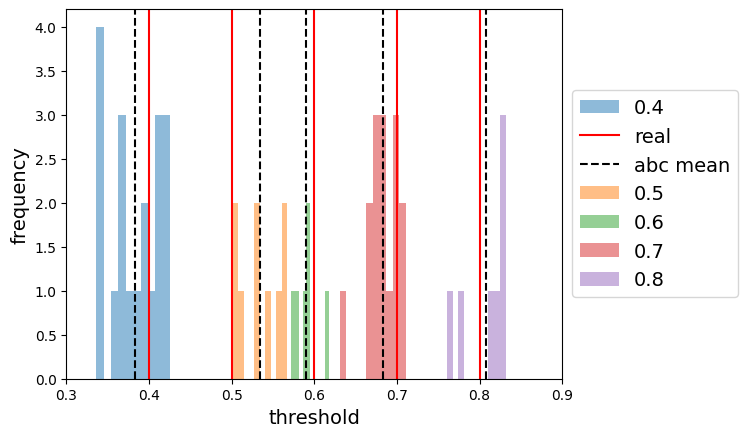

In [53]:
fig = plt.figure()
ax = plt.subplot(111)

for i, t_acc in enumerate(τ_accepted):
    ax.hist(τ_accepted[i], alpha=0.5, label=str(real_tau_list[i]))
    if i == 0:
        ax.axvline(x=real_tau_list[i], color="red", label="real")
        ax.axvline(x=np.mean(τ_accepted[i]), linestyle="--", color="k", label="abc mean")
    else:
        ax.axvline(x=real_tau_list[i], color="red")
        ax.axvline(x=np.mean(τ_accepted[i]), linestyle="--", color="k")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlim([0.3, 0.9])
plt.xlabel("threshold", fontsize=14)
plt.ylabel("frequency", fontsize=14)
plt.show()